<a href="https://colab.research.google.com/github/cppel/dz/blob/main/Task8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №8. Генеративно-состязательная сеть (GAN). Часть 1**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1i3NlGFJbY6hvm-ropSFobW9_nqUcqzPS?usp=sharing)

# Примечание:

Не забывайте периодически сохранять параметры модели. Функции для этого описаны в теоретической части. В случае приостановки процесса обучения из-за перегрузки ОЗУ, Вы сможете загрузить последние предобученные параметры и продолжить обучение.

# **Задание №1.** Обучите генератор воспризводить примитивные изображения. Датасет выберите по желанию. ([Пример](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols))

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
img_rows = 48
img_cols = 64
channels = 1
img_shape = (img_rows, img_cols, channels)

Генератор

In [ ]:
def build_generator():
    noise_shape = (100,)

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    # Генерация изображения

    return Model(noise, img)

Дискриминатор

In [ ]:
def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [ ]:
from tensorflow.keras.models import load_model, save_model
import os

models_path = r'C:\Users\work\Downloads\archive (4)\task8'
gan_path = os.path.join(models_path, "gan")
generator_path = os.path.join(models_path, "generator")
discriminator_path = os.path.join(models_path, "discriminator")

def save(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, gan_path)
    discriminator.trainable = True
    save_model(generator, generator_path)
    save_model(discriminator, discriminator_path)

def load():
    discriminator = load_model(discriminator_path)
    generator = load_model(generator_path)
    gan = load_model(gan_path)
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [ ]:
from sklearn.model_selection import train_test_split
from imutils import paths
import random 
import cv2

def load_data():
    imagePaths = sorted(list(paths.list_images(r"C:\Users\work\Downloads\archive (4)\task8")))
    random.shuffle(imagePaths)
    allX = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_cols, img_rows))
        allX.append(image)

    allX = np.array(allX)
    return (allX, None), (None, None)

Инициализируем модели

In [ ]:
optimizer = Adam(0.0005, 0.5) 

In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,704,961
Trainable params: 1,704,961
Non-

In [ ]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [ ]:
z = Input(shape=(100,))
img = generator(z)

In [ ]:
discriminator.trainable = False

In [ ]:
valid = discriminator(img)

In [ ]:
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(r"C:\Users\work\Downloads\archive (4)\tr", "generated_epoch_%d.png" % epoch) )
    plt.close()

Обучение

In [ ]:
def train(epochs, batch_size=128, save_interval=50):

    (X_train, _), (_, _) = load_data()

    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    X_train = np.expand_dims(X_train, axis=3) 
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):

        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1))) 
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 


        noise = np.random.normal(0, 1, (batch_size, 100)) 

        valid_y = np.array([1] * batch_size)

        g_loss = combined.train_on_batch(noise, valid_y)

        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        if epoch % save_interval == 0:
            save_imgs(epoch)
            if epoch % 1000 == 0:
                save(combined, generator, discriminator)



In [ ]:
train(epochs=100000, batch_size=32, save_interval=2000)

generator.save(os.path.join(r'C:\Users\work\Downloads\models_task8_1', 'latin_generator_model_final_1.h5')) 

0 [D loss: 0.608608, acc.: 56.25%] [G loss: 0.604365]
INFO:tensorflow:Assets written to: C:\Users\work\Downloads\archive (4)\task8\gan\assets
INFO:tensorflow:Assets written to: C:\Users\work\Downloads\archive (4)\task8\generator\assets
INFO:tensorflow:Assets written to: C:\Users\work\Downloads\archive (4)\task8\discriminator\assets
1 [D loss: 0.283439, acc.: 93.75%] [G loss: 0.661351]
2 [D loss: 0.274275, acc.: 93.75%] [G loss: 0.725953]
3 [D loss: 0.328592, acc.: 81.25%] [G loss: 0.809282]
4 [D loss: 0.352019, acc.: 84.38%] [G loss: 1.202447]
5 [D loss: 0.204757, acc.: 87.50%] [G loss: 1.550905]
6 [D loss: 0.189341, acc.: 87.50%] [G loss: 2.084109]
7 [D loss: 0.080005, acc.: 96.88%] [G loss: 2.078310]
8 [D loss: 0.180559, acc.: 90.62%] [G loss: 2.795050]
9 [D loss: 0.102825, acc.: 100.00%] [G loss: 3.604679]
10 [D loss: 0.038398, acc.: 100.00%] [G loss: 3.466966]
11 [D loss: 0.211734, acc.: 87.50%] [G loss: 3.864810]
12 [D loss: 0.027266, acc.: 100.00%] [G loss: 4.391387]
13 [D loss: 

### Демонстрация сгенерированных изображений:

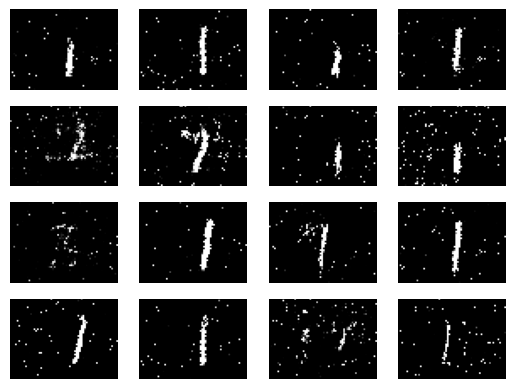

In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt

def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

model = load_model(os.path.join(r'C:\Users\work\Downloads\models_task8_1', 'latin_generator_model_final_1.h5'))

latent_points = generate_latent_points(100, 16) 

X = model.predict(latent_points)

save_plot(X, 4)

# **Задание №2.** Обучите генератор воспризводить сложные изображения. Датасет выберите по желанию. ([Пример](https://www.kaggle.com/datasets/fedesoriano/cifar100))

In [ ]:
# Ваш код

### Демонстрация сгенерированных изображений:

In [ ]:
# Ваш код